<a href="https://colab.research.google.com/github/YasudaKaito/pytorch_book_akaishi/blob/main/ch10_tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. NNの多層化
2. 最適化関数の改善
3. 過学習対策

# 10.2 多層化

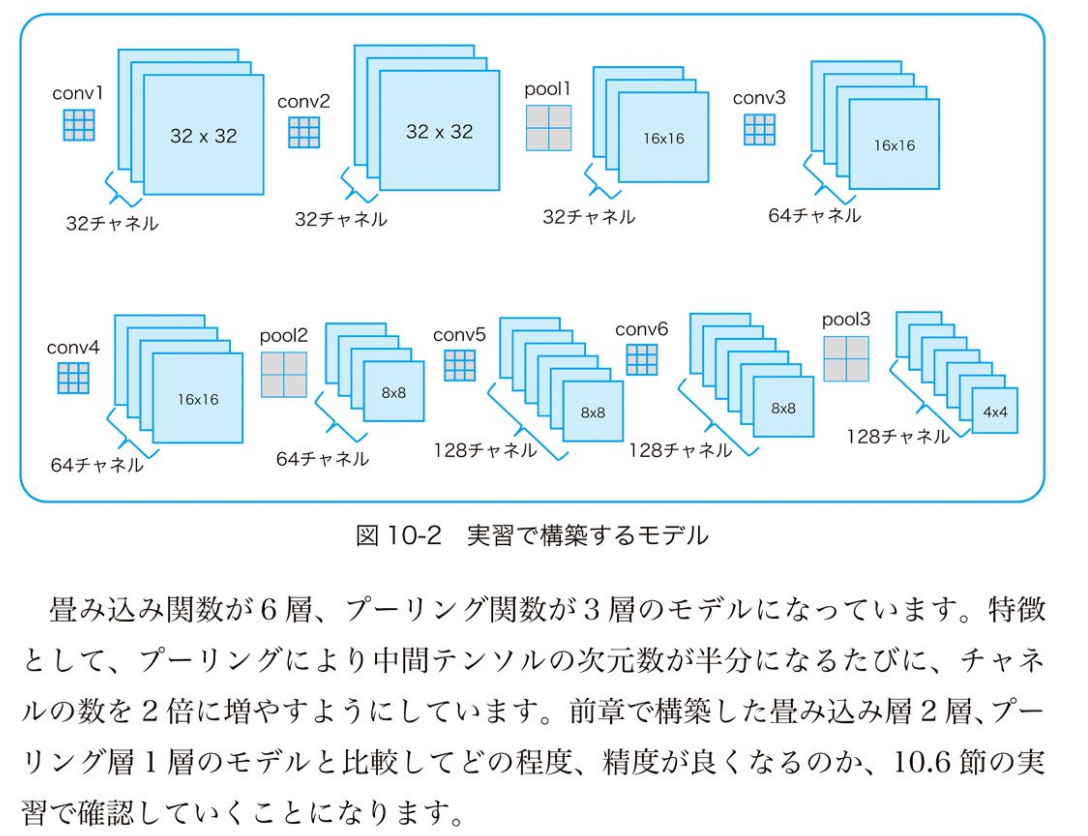

# 10.3 最適化関数の改善

- Momentum
    - SGDが直近の勾配しかパラメータ更新に利用しないのに対し、
    - 過去の勾配も記憶して、その分もパラメータを一定比率で減らしつつパラメータ更新に利用
- Adam
    - 多数のアルゴリズムのいいところを取り入れたもの
    

# 10.4 過学習対策

## ドロップアウト
- レイヤー関数の間に挟む
- ランダムにテンソルの要素を選び、対象に選ばれた要素の出力値を0とする
- 学習ごとにランダムに異なるテンソル要素を選ぶ
- 予測フェーズではドロップアウトの状態をなくしてすべての要素が参加した形で予測する


In [1]:
# 必要ライブラリの導入
!pip install japanize_matplotlib | tail -n 1
!pip install torchinfo | tail -n 1

In [2]:
# 必要ライブラリのインポート

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from IPython.display import display

In [3]:
# PyTorch関連ライブラリのインポート

import torch
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import torchvision.datasets as datasets

In [4]:
# warning表示off
import warnings
warnings.simplefilter('ignore')

# デフォルトフォントサイズ変更
plt.rcParams['font.size'] = 14

# デフォルトグラフサイズ変更
plt.rcParams['figure.figsize'] = (6,6)

# デフォルトで方眼表示ON
plt.rcParams['axes.grid'] = True

# numpyの表示桁数設定
np.set_printoptions(suppress=True, precision=5)

In [5]:
# ドロップアウトの実験
torch.manual_seed(123)
inputs = torch.randn(1, 10)
print(inputs)

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


In [6]:
dropout = nn.Dropout(0.5)

# 訓練フェーズの挙動
dropout.train()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

# 予測フェーズの挙動
dropout.eval()
print(dropout.training)
outputs = dropout(inputs)
print(outputs)

True
tensor([[-0.0000,  0.2407, -0.0000, -0.4808, -0.0000,  0.0000, -1.9447, -0.0000,
          0.6478, -0.2170]])
False
tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969,  0.2093, -0.9724, -0.7550,
          0.3239, -0.1085]])


- 0でない要素は、2倍になっている
    - 「ドロップアウト比率をpとしたとき、出力は 1/(1-p) 倍した値が戻される」
    - 入力値全体の平均がドロップアウト前後で変わらないようにする工夫
    - 今回は p=0.5 のため、2倍

## バッチ正規化

以下、G検定の緑本の内容をまとめた

- 標準化=平均を引いて標準偏差で割る
- 各層におけるミニバッチごとに標準化を行う
- データ分布の偏りをなくし、正規分布に近くなるようにデータを整える
- 通常、線形変換と非線形変換の間に適用する
    - 例：
        - 全結合層と活性化層
        - 畳み込み層と活性化層


In [7]:
# データ拡張
# 正規化に追加で左右反転と RandomErasing を実施
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    # scale: range of proportion of erased area against input image.
    # ratio: range of aspect ratio of erased area.
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

In [8]:
# 著者の共通関数ダウンロード
!git clone https://github.com/makaishi2/pythonlibs.git

Cloning into 'pythonlibs'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 112 (delta 0), reused 2 (delta 0), pack-reused 108
Receiving objects: 100% (112/112), 21.12 MiB | 19.93 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [10]:
!pip install torchviz | tail -n 1

In [11]:
from torchviz import make_dot

In [12]:
from pythonlibs.torch_lib1 import *

In [13]:
# モデル定義
class CNN_v2(nn.Module):
    def __init__(self, num_classes) -> None:
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding="same")
        self.conv2 = nn.Conv2d(32, 32, 3, padding="same")
        self.maxpool = nn.MaxPool2d((2, 2))
        self.conv3 = nn.Conv2d(32, 64, 3, padding="same")
        self.conv4 = nn.Conv2d(64, 64, 3, padding="same")
        self.conv5 = nn.Conv2d(64, 128, 3, padding="same")
        self.conv6 = nn.Conv2d(128, 128, 3, padding="same")
        self.relu = nn.ReLU(inplace=True)
        self.flatten = nn.Flatten()
        # maxpool を3回かけるので画像の辺の長さが 32 -> 16 -> 8 -> 4 になる
        # チャネル数128 のため、flatten すると4*4*128の特徴量となる
        self.l1 = nn.Linear(4*4*128, 128)
        self.l2 = nn.Linear(128, num_classes)

        self.features = nn.Sequential(
            self.conv1,
            self.conv2,
            self.maxpool,
            self.conv3,
            self.conv4,
            self.maxpool,
            self.conv5,
            self.conv6,
            self.maxpool,
        )

        self.classifier = nn.Sequential(
            self.l1,
            self.relu,
            self.l2
        )

    def forward(self, x):
        x1 = self.features(x)
        x2 = self.flatten(x1)
        x3 = self.classifier(x2)
        return x3

In [14]:
# GPUチェック
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [15]:
n_output = 10

torch_seed()

lr = 0.01
net = CNN_v2(n_output).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr)
history = np.zeros((0, 5))

In [16]:
# Transformsの定義
transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(0.5, 0.5)
])

In [17]:
# データ取得用関数 Dataset
data_root = './data'

train_set = datasets.CIFAR10(
    root = data_root, train = True,
    download = True, transform = transform)

# 検証データの取得
test_set = datasets.CIFAR10(
    root = data_root, train = False,
    download = True, transform = transform)

100%|██████████| 170498071/170498071 [00:11<00:00, 14369197.39it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [18]:
# ミニバッチのサイズ指定
batch_size = 100

# 訓練用データローダー
# 訓練用なので、シャッフルをかける
train_loader = DataLoader(train_set,
    batch_size = batch_size, shuffle = True)

# 検証用データローダー
# 検証時にシャッフルは不要
test_loader = DataLoader(test_set,
    batch_size = batch_size, shuffle = False)

In [19]:
num_epochs = 30
history = fit(
    net,
    optimizer,
    criterion,
    num_epochs,
    train_loader,
    test_loader,
    device,
    history
)

  0%|          | 0/500 [00:00<?, ?it/s]

Epoch [1/30], loss: 2.27792 acc: 0.13382 val_loss: 2.13256, val_acc: 0.22640


  0%|          | 0/500 [00:00<?, ?it/s]

KeyboardInterrupt: 